# Assignment 2

## Exercise 1.2

The aim of this exercise is to show that graph generation methods obey the theoretical degree distribution: P(k) = C_k^{n-1}p^k(1-p)^{n-k-1}.

In order to do that, we will do the following experiment
- Generate a random graph following Erdos-Renyi G(n=1000, p=0.65) model
- We consider all degrees and count how many times each degree appear
- We obtain a sample of size n for which we assume that it was generate by a binomial distribution
- Use Chi-square test to test our hypothesis

### Generating sample

In [1]:
import os, sys, math
import collections as collcs
# append the path so that modules can be properly imported
sys.path.append('../src/')

import graph
import algorithms.erdos_renyi as er
import algorithms.newman_model as nm

reload(graph)
reload(er)
reload(nm)

<module 'algorithms.newman_model' from '../src/algorithms/newman_model.pyc'>

In [2]:
n, p, seed = 1000, 0.4, 12345
G = er.er_np(n, p, seed=seed)
m = (n*(n-1)/2.0)*p
m = int(math.floor(m))
G1 = er.er_nm(n, m)

### Processing sample

Now we will count how many times each number from the set $\{1,\dots,n-1\}$ appears.

In [3]:
g_degree_sequence = G.degree_sequence()
g1_degree_sequence = G1.degree_sequence()
num_counter, num_counterG1 = {}, {}
for i in range(n):
    num_counter[i] = num_counterG1[i] = 0

for d1, d2 in zip(g_degree_sequence, g1_degree_sequence):
    num_counter[d1] += 1
    num_counterG1[d2] += 1

### Chi-square test

A description of chi-square test can be found on the following [link](https://en.wikipedia.org/wiki/Chi-squared_test).

In order to do the chi-squared test, we will need:
- observed number of appearing of each number in our sample (*num_counter*)
- expected number of observations: we will get this by computing probability for each number and multiplying with number of samples

*Note*: In the next block of code, we will use python modules **scipy, numpy** and **matplotlib**.

Let's firstly draw a histogram of binomial distribution with parameters *n* and *p*.

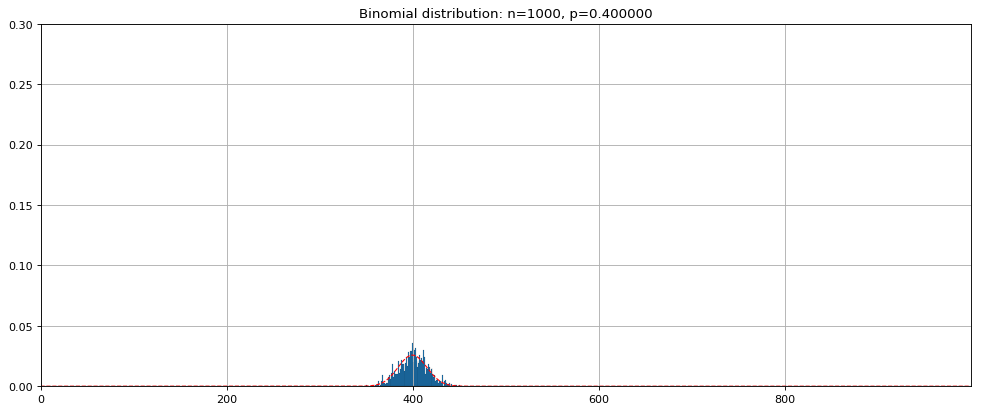

/home/vladan/.local/lib/python2.7/site-packages/scipy/stats/stats.py:4544: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


Chi-value: nan, p-value: nan
******************Second test*******************


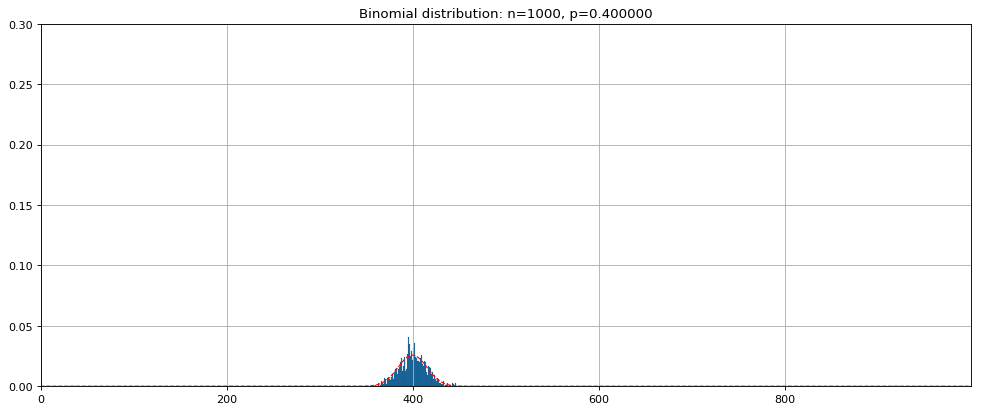

Chi-value: nan, p-value: nan


In [4]:
import scipy.stats as stat
import numpy as np
import matplotlib.pyplot as plt

def plot_test(n, p, degree_sequence, counter, title="Plot"):
    # plot setup
    plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='white', edgecolor='green')
    
    # Binomial pmf with parameters n-1, p
    x_axis = np.linspace(0, n-1, n)
    y_axis = np.array([stat.binom.pmf(i, n-1, p) for i in range(n)]) #stat.binom.pmf(x_axis, n-1, p)
    # display degree distribution and binomial pmf
    #print("deg seq")
    #print(degree_sequence)
    my_counter, bins, patches = plt.hist(degree_sequence, x_axis, normed=1.0, edgecolor='k', linewidth=0.1)
    plt.title("Binomial distribution: n=%d, p=%f" % (n, p))
    plt.plot(x_axis, y_axis, 'r--', linewidth=1)
    plt.grid(True)
    plt.axis([0, n-1, 0, 0.3])
    plt.show()

# compute observed and expected
    observed = np.array([counter[i] for i in range(n)]) # fix this.
    expected = y_axis * n  #we multiply it by number of observations

# do the test
    chi, p_value = stat.chisquare(observed, expected, ddof=n-1)
    print("Chi-value: %f, p-value: %f" % (chi, p_value))
    
# G(n, p) model
plot_test(n, p, g_degree_sequence, num_counter, title="Plot2")
print("******************Second test*******************")
num_counterG1[0]=0
plot_test(n, p, g1_degree_sequence, num_counterG1, title="Plot1")

In the above figure, we see that degree sequence looks very similar to binomial pmf. Also, *p-value* of our test is 1.0 which gives a strong evidence in a favour of the null hypothesis, i.e., degree sequence was generated by a binomial distribution.

## Exercise 2

In this exercise, we want to demonstrate the following:
- if $np < 1$, a graph in $G_{n,p}$ will almost surely have no connected components of size larger than $O(\log n)$
- if $np = 1$, a graph in $G_{n,p}$ will almost surely have a largest component whose size is $O(n^\frac{2}{3})$,
- if $np \to c > 1$, where c is a constant, then a graph in $G_{n,p}$ will almost surely have a unique giant component containing a positive fraction of the vertices. No other component will contain more than $O(\log n)$ vertices. Furthermore,
- if $np < (1 − \epsilon)\log n$, a graph in $G_{n,p}$ will almost surely contain isolated vertices, and
- if $np > (1 + \epsilon)\log n$, a graph in $G_{n,p}$ will almost surely be connected.

To do so, we will do the following experiments.

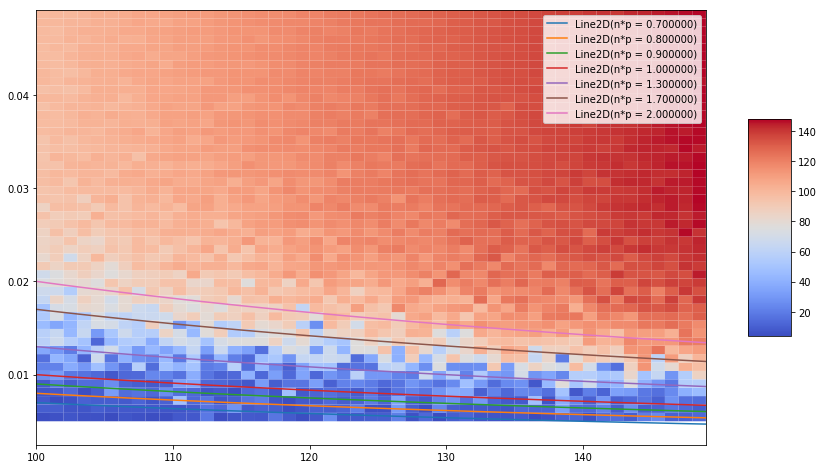

In [5]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import matplotlib.pyplot as plt

def component_experiment((n_l, n_r), (p_l, p_r), seeds = None, offset = 3):
    # n_l, n_r bounds for n
    # p_l, p_r bounds for probability
    # s sample size
    # generate s graphs from G(n,p)
    s = n_r - n_l # sample size
    if seeds is None:
        seeds = np.random.choice(2000000, s*s).reshape((s, s))
    # compute
    
    step_p = float(p_r - p_l) / float(s)
    
    N = np.arange(n_l, n_r, step=1)
    P = np.arange(p_l, p_r, step=step_p)
    
    N, P = np.meshgrid(N, P)
    CC = np.zeros((s, s))
    # r_graphs = []
    for i in range(s):
        # r_graphs.append([])
        for j in range(s):
            G = er.er_np(int(N[i, j]), P[i, j], seed=seeds[i, j])
            # r_graphs[-1].append(G)
            cc_sizes = G.connected_component()[1]
            
            # get the largest
            largest_comp_size = 0 if len(cc_sizes) == 0 else max(cc_sizes)
            # print("Largest comp of graph (%d, %f) is %d" % (int(N[i, j]), P[i, j], largest_comp_size))
            CC[i, j] = largest_comp_size
    
    plot3D(N, P, CC)
        
        

def plot3D(X, Y, Z):
    # plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
    fig = plt.figure(figsize=(15, 8))
    mapa = plt.pcolor(X, Y, Z, cmap=cm.coolwarm, antialiased=True)
    fig.colorbar(mapa, shrink=0.5, aspect=5)
    
    # plot a few lines
    tX = X[1]
    n_times_p = [0.7, 0.8, 0.9, 1.0, 1.3, 1.7, 2.0]
    lines = []
    for prod in n_times_p:
        line, = plt.plot(tX, prod / tX, label="n*p = %f"%prod)
        lines.append(line)
    
    plt.legend(lines)
    
    plt.show()
    
component_experiment((100, 150), (0.005, 0.05))

In the above graph, $x$-axis represents number of nodes our graph has, $y$-axis is probability $p$. We plot different lines as a function of $n$ and $p$. More precisely, we plot 7 lines with $n\cdot p \in \{.7, .8, .9, 1.0, 1.3, 1.7, 2.0\}$. We can see that when $n\cdot p < 1$, the size of the largest component is below 20 (with a few exceptions). This confirms that if $np < 1$ then the size of the largest component belongs to $O(\log n)$. 
From the other side, if $np = 1$ (the red line), we see that the size of the largest component is between $20$ and $60$. Again, this is a good evidence that the size of the largest component is of order $O(n^{\frac{2}{3}})$.

One of the things that can be seen in the above plot is that there is a sharp threshold for the size of largest component. Although it is not true that the threshold is $np = 1$, we can see that the threshold line satisfies $np = c$. Thus, increasing $n$ should solve this. 

Finally, let us try to estimate number of isolated vertices.

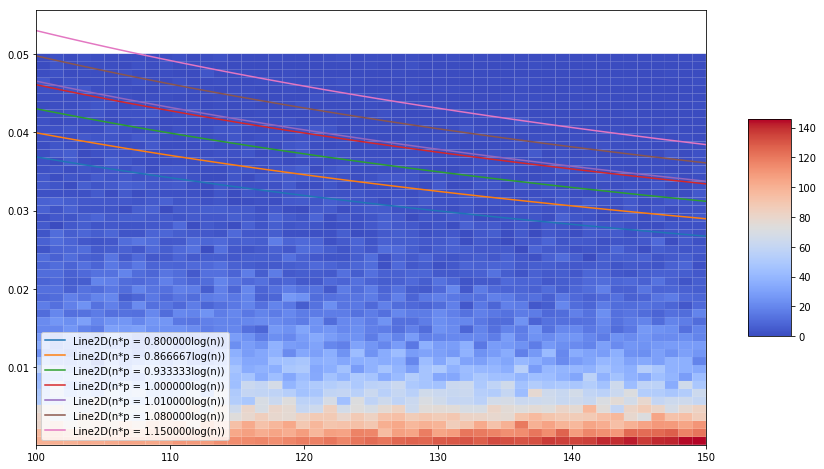

In [17]:
# number of isolated vertices when np in [(1-e)logn, (1+e)logn] for n in [100, 200] and p in [0.02, 0.5]

n_l, n_r = 100, 150
p_l, p_r = 0.0001, 0.05
epsilon = np.concatenate((np.linspace(-0.2, 0.0, 4), np.linspace(0.01, 0.15, 3)))
p_size = n_size = int(n_r - n_l)
N, P = np.linspace(n_l, n_r, n_size), np.linspace(p_l, p_r, p_size)

N, P = np.meshgrid(N, P)
CC = np.zeros((n_size, p_size))

for i in range(n_size):
    for j in range(p_size):
        G = er.er_np(int(N[i, j]), P[i, j])
        isolated_vertices = G.find_isolated_vertices()
        CC[i, j] = len(isolated_vertices)

fig = plt.figure(figsize=(15, 8))
mapa = plt.pcolor(N, P, CC, cmap=cm.coolwarm, antialiased=True)
fig.colorbar(mapa, shrink=0.5, aspect=5)

X = N[0]
lines = []
for prod in epsilon:
    line, = plt.plot(X, ((1+prod)*np.log(X))/X, label="n*p = %flog(n)"%(1+prod))
    lines.append(line)

plt.legend(lines)

plt.show()


The above plot represents the number of isolated vertices as a function of $n$ and $p$. We also see 7 lines representing equations $n\cdot p = (1+\epsilon)\log(n)$ for $\epsilon \in [-0.2, 0.15]$.

We can observe the follwoing:
- when $n\cdot p > 1.15\log(n)$ (everything above the pink line), there is no isolated vertices
- when $n\cdot p < 0.8\log(n)$ (everything below the blue line), we see that almost all graphs have at least one isolated vertex